In [1]:
from matplotlib import pyplot as plt
import sys
sys.path.append("src")
sys.path.append("src/script/")
import numpy as np

import argparse
from model import *
import torch.optim as optim


import pickle

def get_log_path(model):
    i = 1
    while os.path.exists(os.path.join(model.ec.exp_path, f"online_{i}.log")):
        i += 1
    path = os.path.join(model.ec.exp_path, f"online_{i}.log")
    print(path)
    return path

threads_num = "6"

os.environ["OMP_NUM_THREADS"] = threads_num 
os.environ["OPENBLAS_NUM_THREADS"] = threads_num 
os.environ["MKL_NUM_THREADS"] = threads_num 
os.environ["VECLIB_MAXIMUM_THREADS"] = threads_num 
os.environ["NUMEXPR_NUM_THREADS"] = threads_num 



In [3]:
# model = GCNICF(para_dict, ec)

path = "Exp/ml-100k/GCNICF/F5_--K_5_1/save/"

dls = load_class(path + "dls.class")
model = load_class(path + "model.class")
ui_cls = load_class(path + "ui_cls.class")

model.print = print
ui_cls.print = print


In [4]:
model.online_init(ui_cls, dls)

uid = dls.online_id[0]

user = ui_cls.get_user_by_id(uid)

In [5]:
candidate_item_id_set = user.online_candidate_list

if model.explore_method == "UCB":
    candidate_index = [ ui_cls.index["item"]["id2index"][id] for id in candidate_item_id_set]

    items_mu = model.FI_mu[candidate_index] # (n,d)
    items_var = model.FI_var[candidate_index] # (n,d)

    if hasattr(user, "online_mu"):
        user_vec = user.online_mu
    else:
        user_vec = np.zeros(model.dim)
    
    if hasattr(user, "online_cov"):
        cov = user.online_cov
    else:
        cov = np.eye(model.dim) 

    var = ((items_mu @ cov ) * items_mu).sum(1)  +  (items_var * user_vec ) @ user_vec + items_var @ np.diag(cov)
    score_vec = items_mu @ user_vec + model.explore_v * np.sqrt( np.log(user.online_round + 2) * var)

    pos_vec = [ui_cls.get_item_by_index(i).pos for i in candidate_index]

    pop_vec = [ui_cls.get_item_by_index(i).pop for i in candidate_index]


In [26]:
item = ui_cls.get_item_by_id(53)
item.index
item.pos
np.std(item.feedback)
mu = model.FI_mu[item.index]
np.sqrt( (mu @ (cov @ mu) + 0 + model.FI_var[item.index] @ np.diag(cov)) * np.log(2) )

score_vec.max()

195

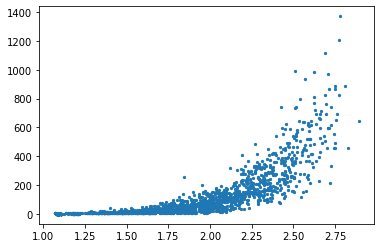

In [6]:
plt.scatter(score_vec,pos_vec, s = 5)


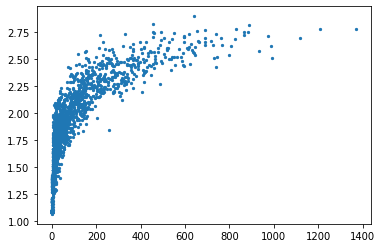

In [7]:
plt.scatter(pos_vec, score_vec, s = 5)
plt.xlabel("pos")
plt.ylabel("score")

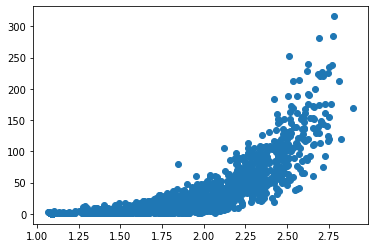

In [8]:
plt.scatter(score_vec, pop_vec)